<a href="https://colab.research.google.com/github/Olena-24/Science-HW/blob/main/HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [32]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [33]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

In [49]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer_1 = DenseLayer(num_features, n_hidden_1)
    # Другий шар, який складається з 256 нейронів
    self.layer_2 = DenseLayer(n_hidden_1, n_hidden_2)
    # Вихідний шар
    self.out_layer = DenseLayer(n_hidden_2, num_classes)


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    x3 = self.out_layer(x2, activation=1)

    # Пам'ятайте, що для виходу нейронної мережі ми застосовуємо до виходу функцію softmax.
    # Робимо ми це для того, щоб
    # вихід нейронної мережі приймав значення від 0 до 1 відповідно до ймовірності
    # Приналежності вхідного об'єкта до одного з 10 класів

    return x3

In [51]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

In [52]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)
    # Створимо список параметрів, що оптимізуються.
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [53]:

## Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    train(neural_net, batch_x, batch_y)
    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)

        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        print(f"Step: {step}, Loss: {current_loss}, Accuracy: {current_accuracy}")

Step: 100, Loss: 309.1058654785156, Accuracy: 0.66796875
Step: 200, Loss: 210.2187957763672, Accuracy: 0.74609375
Step: 300, Loss: 218.30587768554688, Accuracy: 0.7578125
Step: 400, Loss: 150.85467529296875, Accuracy: 0.828125
Step: 500, Loss: 139.7798614501953, Accuracy: 0.8671875
Step: 600, Loss: 100.69844055175781, Accuracy: 0.90625
Step: 700, Loss: 95.09429931640625, Accuracy: 0.90625
Step: 800, Loss: 89.68553924560547, Accuracy: 0.87109375
Step: 900, Loss: 110.7413330078125, Accuracy: 0.890625
Step: 1000, Loss: 88.1561508178711, Accuracy: 0.88671875
Step: 1100, Loss: 107.49354553222656, Accuracy: 0.875
Step: 1200, Loss: 90.26437377929688, Accuracy: 0.87890625
Step: 1300, Loss: 81.54925537109375, Accuracy: 0.87109375
Step: 1400, Loss: 48.9006462097168, Accuracy: 0.91796875
Step: 1500, Loss: 66.96566772460938, Accuracy: 0.90625
Step: 1600, Loss: 75.74352264404297, Accuracy: 0.90625
Step: 1700, Loss: 61.40058135986328, Accuracy: 0.91796875
Step: 1800, Loss: 62.600189208984375, Accura

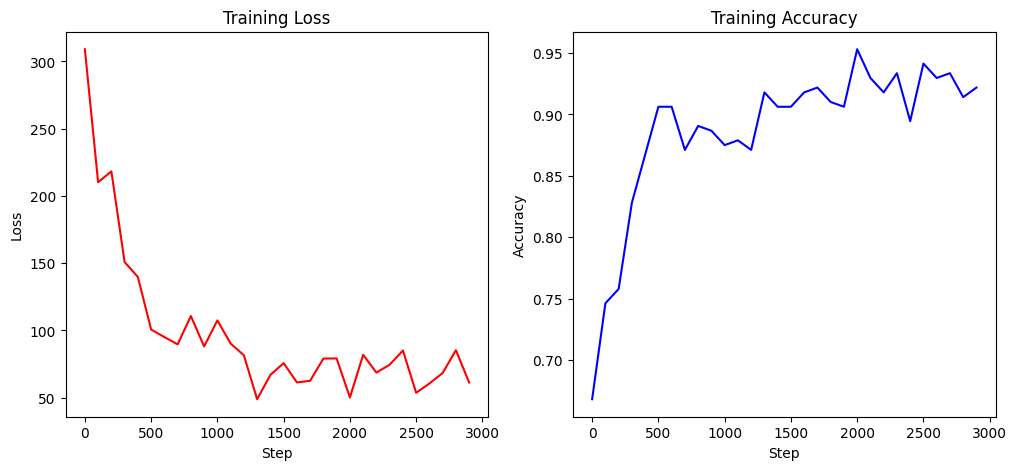

In [55]:
# Виведіть графік функції втрат

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(0, training_steps, display_step), loss_history, 'r')
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')

# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(range(0, training_steps, display_step), accuracy_history, 'b')
plt.title('Training Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')

plt.show()

In [57]:
# Обчисліть точність навченої нейромережі
test_pred = neural_net(x_test)
test_acc = accuracy(test_pred, y_test)
print(f"Test Accuracy: {test_acc.numpy()}")

Test Accuracy: 0.900600016117096


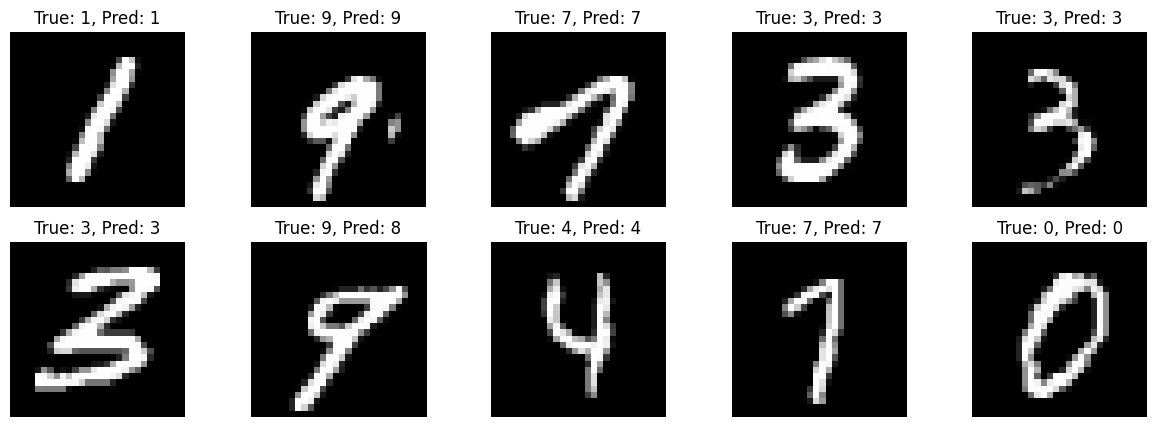

Model made 1 errors out of 10 images.
Accuracy on this sample: 90.00%


In [58]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

# Виберіть 10 випадкових зображень з тестової вибірки
random_indices = np.random.choice(len(x_test), size=10, replace=False)
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

# Передайте зображення в нейронну мережу для передбачення
predictions = neural_net(sample_images)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Виведіть зображення та передбачення нейронної мережі
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title(f"True: {sample_labels[i]}, Pred: {predicted_labels[i]}")
    plt.axis('off')
plt.show()

# Висновок про точність моделі
num_errors = np.sum(predicted_labels != sample_labels)
accuracy = (10 - num_errors) / 10.0 * 100
print(f"Model made {num_errors} errors out of 10 images.")
print(f"Accuracy on this sample: {accuracy:.2f}%")

In [59]:
from sklearn.metrics import classification_report

# Передбачення нейромережі на тестових даних
test_pred = neural_net(x_test)
test_pred_classes = np.argmax(test_pred, axis=1)

# Виведення метрик якості для кожного класу
report = classification_report(y_test, test_pred_classes, target_names=[str(i) for i in range(num_classes)])
print(report)

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       980
           1       0.95      0.98      0.97      1135
           2       0.88      0.90      0.89      1032
           3       0.87      0.89      0.88      1010
           4       0.88      0.90      0.89       982
           5       0.90      0.83      0.87       892
           6       0.91      0.93      0.92       958
           7       0.92      0.90      0.91      1028
           8       0.87      0.86      0.86       974
           9       0.87      0.86      0.86      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000




**Висновки**


Результати навчання нейронної мережі та її тестування показують, що модель демонструє високу точність у розпізнаванні рукописних цифр з бази даних MNIST. Загальна точність моделі становить 90%. Точність (precision), повнота (recall) і F1-оцінка для кожного класу показують, що модель добре працює з усіма цифрами. Найвищі показники мають класи 1 та 0, де F1-оцінка складає 0.97 та 0.94 відповідно.
Найнижчі показники мають класи 5, 8 та 9, де F1-оцінка складає 0.87 та 0.86 відповідно.